Sina Heydari
sinaheyd@usc.edu

## $a y' - ky''=0$
by solving the characteristic equation we arrive at:
## $y = c_1 + c_2 e^{ax/k}$

and the coefficients are found from the B.C. to be $c_1 = -\dfrac{1}{e^{a/k} -1}$ and $c_2 =\dfrac{1}{e^{a/k} -1} $

In [ ]:
def exact_sol(x,a):
  k = 1
  c2 = 1/(np.exp(a/k)-1)
  c1 = -c2
  y = c1 + c2*np.exp(a*x/k)
  return y
  

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.pyplot import figure
from tensorflow import keras
tf.random.set_seed(1)


In [ ]:
# part 2 - 
def MLP(input_dim=1, output_dim=1, width=15, depth=8):

  reg_param=1e-7
  initializer = tf.keras.initializers.RandomNormal()

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten())
  
  # adding hidden layers
  for i in range(depth-1):
    model.add(tf.keras.layers.Dense(width, activation = tf.math.sin, kernel_initializer='RandomNormal', bias_initializer='RandomNormal',
                                    kernel_regularizer=tf.keras.regularizers.L2(reg_param))) 

  # adding output layer
  model.add(tf.keras.layers.Dense(output_dim, activation=None, kernel_initializer='RandomNormal', bias_initializer='RandomNormal',
                                  kernel_regularizer=tf.keras.regularizers.L2(reg_param)))
  return model



In [ ]:
mse = keras.losses.MeanSquaredError()

# Define custom loss function
def my_loss(x, lambda_b, a, k, N):
  
  x = tf.reshape(x, (N, 1))
  x = tf.dtypes.cast(x, tf.float32)
  
  # print(u)
  
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    u  = model(x, training=True) 
    du_dx = tape.gradient(u,x)
    with tf.GradientTape(persistent=True) as tape2:    
      d2u_dx2 = tape.gradient(du_dx,x)  
  

  int_res = (1/N)*(tf.reduce_sum(tf.square(a*du_dx - k*d2u_dx2 )))
  bound_res = tf.reduce_mean(tf.square(u[0]) + tf.square(u[N-1]-1))
  loss = (1/N)*(tf.reduce_sum(tf.square(a*du_dx - k*d2u_dx2 ))) + lambda_b*tf.reduce_mean(tf.square(u[0]) + tf.square(u[N-1]-1)) 

  return [loss, int_res, bound_res]
    

  

In [ ]:
Input_Dim = 1
Output_Dim = 1
Width = 20
Depth = 8
lambda_b = 10
k = 1
N_arr = [25, 50]
a_arr = [2, 5, 10]

max_epoch  = 1000

# val_loss_history = np.zeros((6, N_arr))
int_res_history = np.zeros((max_epoch,6))
bound_res_history = np.zeros((max_epoch,6))
# val_loss_history = np.zeros((3,num_epochs, len(reg_arr)))
predicted_sol = []
# predicted_sol = np.zeros((50, 6))

model = MLP(Input_Dim,Output_Dim,Width,Depth)
# model.summary()
optimizer  = keras.optimizers.Adam(learning_rate=1e-3)
for a_index in range(len(a_arr)):
  for N_index in range(len(N_arr)):
    x_train = tf.linspace(0,1,N_arr[N_index])
    print('For a = {} and N = {}'.format(a_arr[a_index],N_arr[N_index]))
    # 'For regularization param = {}'.format(reg_arr[ind])
    counter = len(N_arr)*a_index+N_index
    print(counter)
    for epoch in range(max_epoch):
        
        with tf.GradientTape() as tape:
                
            gen_out  = model(x_train, training=True)

            # loss_val = mse(y_train, gen_out). # mean square error of real output and model output
            residual = my_loss(x_train, lambda_b, a_arr[a_index], k, N_arr[N_index])
            
            # print(residue[0],loss_val)
            # loss_val = my_loss(x_train, lambda_b, a_arr[a_index], k )  # our own defined loss
            # loss_val = my_loss(gen_out)
            #loss_val = my_mse(y_train, gen_out,10)
        loss_val = residual[0]
        int_res_history[epoch,counter] = residual[1]
        bound_res_history[epoch,counter] = residual[2]  
        grads = tape.gradient(loss_val, model.trainable_variables)    # take gradient
        # print(loss_val)
        # print(model.trainable_variables)
        
        optimizer.apply_gradients(zip(grads, model.trainable_variables)) # zip used to create an iterator over the tuples

        if epoch % 200 == 0:
            print("Epoch: (%d), loss: (%e)" %(epoch,loss_val))
        if epoch == max_epoch-1:
          predicted_sol.append(model.predict(x_train))
          #predicted_sol[:model.predict(x_train).shape[0],counter] = (model.predict(x_train)).flatten() 
        

For a = 2 and N = 25
0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: (0), loss: (1.250482e+01)
Epoch: (200), loss: (2.362577e+00)
Epoch: (400), loss: (5.002734e-02)
Epoch: (600), loss: (8.756271e-04)
Epoch: (800), loss: (4.403143e-04)
For a = 2 and N = 50
1
Epoch: (0), loss: (2.921232e-04)
Epoch: (200), loss: (4.551899e-04)
Epoch: (400), loss: (1.393191e-04)
Epoch: (600), loss: (8.374978e-05)
Epoch: (800), loss: (5.832803e-05)
For a = 5 and N = 25
2
Epoch: (0), loss: (1.235711e+01)
Epoch: (200), loss: (1.085899e-01)
Epoch: (400), loss: (7.39

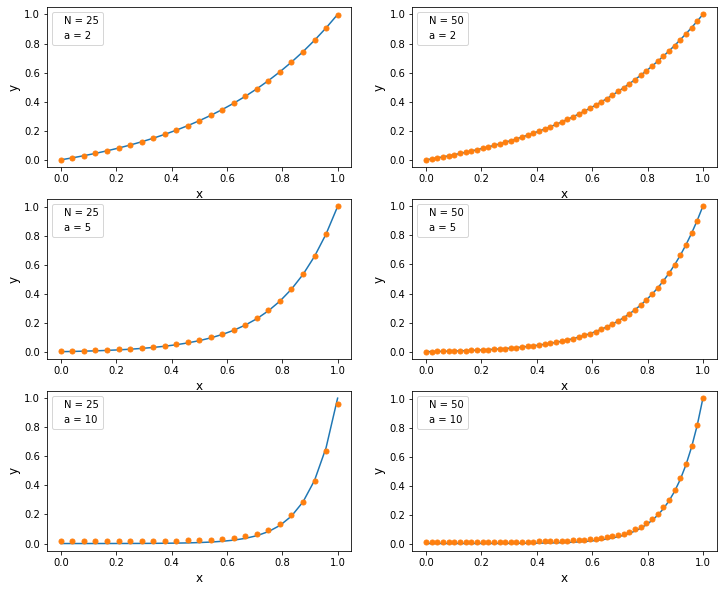

In [ ]:
fig, axs = plt.subplots(len(a_arr), len(N_arr), figsize=(12, 10))
for a_ind in range(len(a_arr)):
  for N_ind in range(len(N_arr)):
    counter = len(N_arr)*a_ind+N_ind

    x_train = tf.linspace(0,1,N_arr[N_ind]) 
    axs[a_ind, N_ind].plot(x_train,exact_sol(x_train,a_arr[a_ind]),'-',label='exact')
    axs[a_ind, N_ind].plot(x_train,predicted_sol[counter],'.',markersize=10,label='NN')

    leg_items = [Patch(label='N = {}'.format(N_arr[N_ind])), Patch(label='a = {}'.format(a_arr[a_ind]))]
    axs[a_ind, N_ind].legend(handles=leg_items, loc='upper left', handlelength=0)
    axs[a_ind, N_ind].set_ylabel('y',fontsize=12)
    axs[a_ind, N_ind].set_xlabel('x',fontsize=12)
    # axs[N_ind, a_ind].set_ylim(-1.2, 1.2)

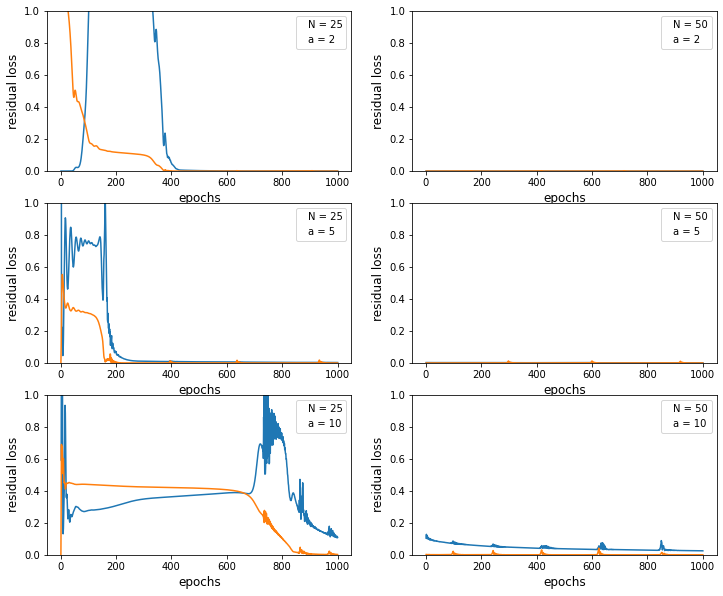

In [ ]:
fig, axs = plt.subplots(len(a_arr), len(N_arr), figsize=(12, 10))
for a_ind in range(len(a_arr)):
  for N_ind in range(len(N_arr)):
    counter = len(N_arr)*a_ind+N_ind
    # x_train = tf.linspace(0,1,N_arr[N_ind]) 
    # axs[N_ind, a_ind].plot(x_train,exact_sol(x_train,a_arr[a_ind]),'-',label='exact')
    axs[a_ind, N_ind].plot(tf.linspace(1,max_epoch,max_epoch),int_res_history[:,counter])
    axs[a_ind, N_ind].plot(tf.linspace(1,max_epoch,max_epoch),bound_res_history[:,counter])
    # axs[N_ind, a_ind].plot(x_train,model.predict(x_train),'-',markersize=10,label='NN')
    leg_items = [Patch(label='N = {}'.format(N_arr[N_ind])), Patch(label='a = {}'.format(a_arr[a_ind]))]
    axs[a_ind, N_ind].legend(handles=leg_items, loc='upper right', handlelength=0)
    axs[a_ind, N_ind].set_ylabel('residual loss',fontsize=12)
    axs[a_ind, N_ind].set_xlabel('epochs',fontsize=12)
    axs[a_ind, N_ind].set_ylim(0, 1)

5(a): For fixed a, as N is increased we can see the loss decreases significantyl and  more quickly. 

5(b): It's harder to train the network as a is increased. This is evident in the figure above, where for N = 25 and a = 10, where the network really has trouble training the network. It is harder to train the network because the derivative terms in the interior residual loss are harder to compute, especially when N is not fine enough and the accuracy drops.

5(c): If $\lambda=0$, then the networks ignores the boundary residual term in the loss function and will only optimzie for the interior residual only. In the case of this problem it will convinently give us the solution of $u=0$ since it satisfies the interior residual loss. but of course is wrong.

